In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tszip

import sys
sys.path.append("../../sc2ts")
import sc2ts
import sc2ts.utils

In [2]:
ts = tszip.decompress("../data/upgma-full-md-30-mm-3-2021-06-30-recinfo2-gisaid-il.ts.tsz")
ti = sc2ts.utils.TreeInfo(ts)

Classifying mutations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1213193/1213193 [00:11<00:00, 102144.11it/s]


In [4]:
ti

,value
property,
latest_sample,2021-06-30
max_submission_delay,29 days
samples,1265685
nodes,1453347
mc_nodes,40292
pr_nodes,40538
re_nodes,4123
recombinants,4123
mutations,1213193


In [5]:
df = ti.export_recombinant_breakpoints()
df

,causal_strain,causal_date,causal_lineage,node,max_descendant_samples,num_parents,total_cost,is_hmm_mutation_consistent,is_arg_hmm_path_identical,is_arg_hmm_path_length_consistent,...,is_parent_lineage_consistent,breakpoint,breakpoint_interval_left,breakpoint_interval_right,left_parent,right_parent,left_parent_imputed_lineage,right_parent_imputed_lineage,mrca,mrca_date
0,USA/WA-UW-2142/2020,2020-03-25,B.1.320,6799,1,2,4,True,True,True,...,True,379,92,380,1748,3829,B.1.371,B.1.320,1484,2020-03-08
1,Luxembourg/LNS0522318/2020,2020-04-04,B.1,10617,1,2,6,True,True,True,...,True,4320,2832,4321,9153,7627,B.1,B.1,179,2020-02-20
2,Luxembourg/LNS2129030/2020,2020-04-23,B.1,14596,1,2,6,True,True,True,...,True,2831,2828,2832,9153,3057,B.1,B.1,179,2020-02-20
3,India/TG-CCMB-L1090/2020,2020-05-13,B.1.1.306,17375,4,2,6,True,True,True,...,True,27382,25424,27383,17236,10105,B.1.1.306,B.1.1,179,2020-02-20
4,India/TG-CCMB-L1470/2020,2020-05-25,B.1,18231,2,2,3,True,True,True,...,True,27379,26736,27380,1089,17374,B.1,B.1.1.306,179,2020-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,Sweden/1468797164/2021,2021-06-30,B.1.1.7,1451366,1,2,9,True,False,False,...,False,8178,5389,8179,221898,1173001,B.1.1.7,B.1.1.7,64513,2020-09-14
4796,Sweden/4085798763/2021,2021-06-30,AY.122,1451405,1,3,16,True,True,True,...,True,22917,21619,22918,1145815,1335255,AY.122,Unknown (R),179,2020-02-20
4797,Sweden/4085798763/2021,2021-06-30,AY.122,1451405,1,3,16,True,True,True,...,True,28280,28112,28281,1335255,1395206,Unknown (R),B.1.1.7,179,2020-02-20
4798,USA/NC-CDC-LC0090621/2021,2021-06-30,B.1.1.7,1452444,1,2,8,False,True,True,...,False,9442,7043,9443,14699,808788,B.1.1,B.1.1.7,179,2020-02-20


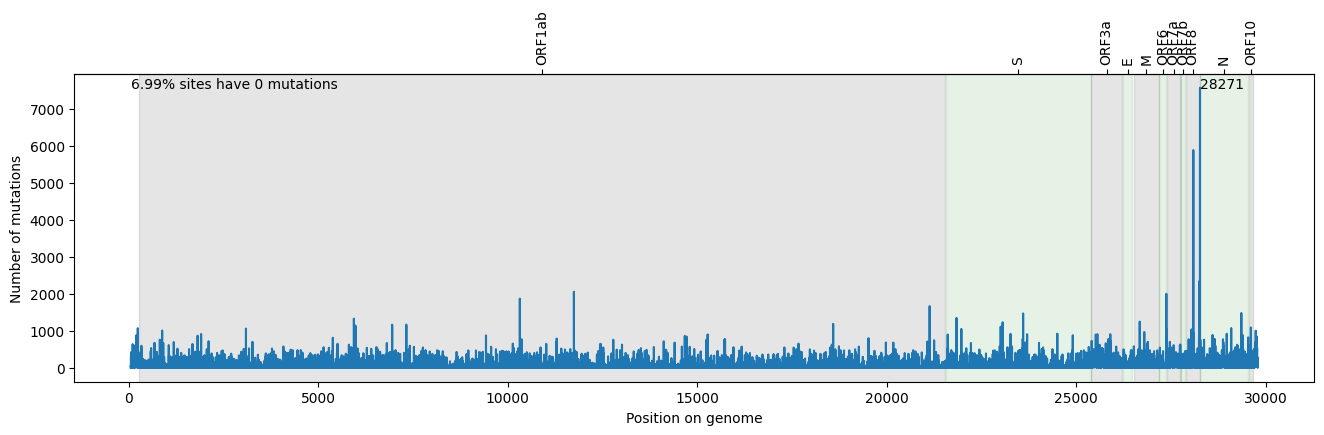

In [15]:
ti.plot_mutations_per_site()

In [16]:
genes = sc2ts.core.get_gene_coordinates()
genes


{'ORF1ab': (266, 21555),
 'S': (21563, 25384),
 'ORF3a': (25393, 26220),
 'E': (26245, 26472),
 'M': (26523, 27191),
 'ORF6': (27202, 27387),
 'ORF7a': (27394, 27759),
 'ORF7b': (27756, 27887),
 'ORF8': (27894, 28259),
 'N': (28274, 29533),
 'ORF10': (29558, 29674)}

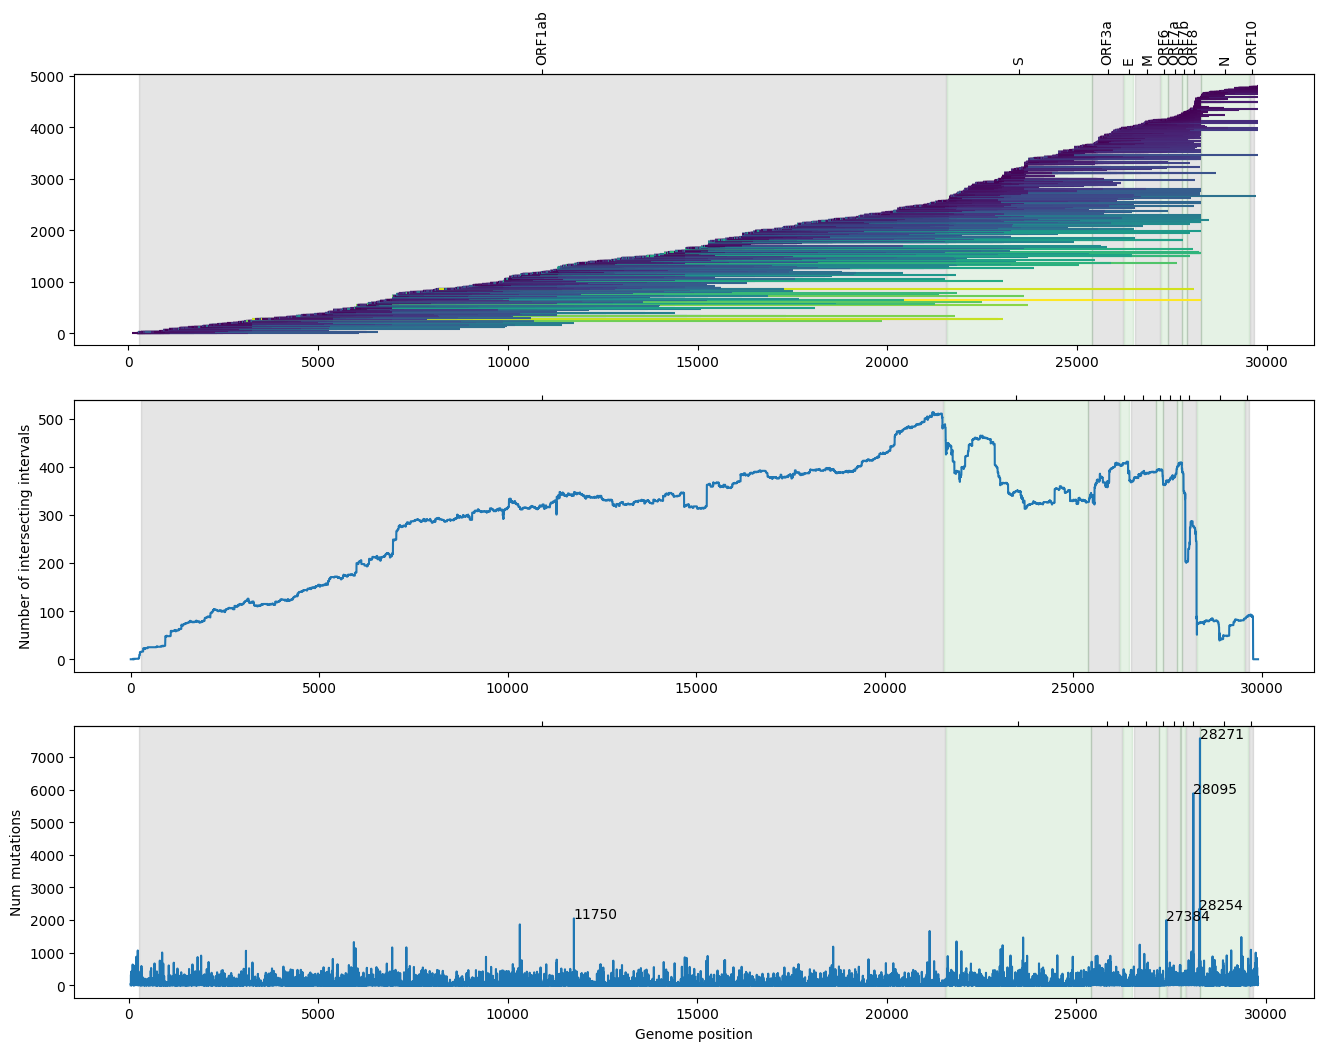

In [17]:
import pylab as pl
from matplotlib import collections  as mc
import matplotlib

def plot_breakpoints(df, ti, xlim=None, mutations_threshold=0.9, unique_only=False):
    dfs = df.sort_values(["breakpoint_interval_left", "breakpoint_interval_right"])
    length = dfs.breakpoint_interval_right - dfs.breakpoint_interval_left
    intervals = [(row.breakpoint_interval_left, row.breakpoint_interval_right) for (_, row) in dfs.iterrows()]
    if unique_only:
        unique = set(intervals)
        intervals = sorted(unique)
    
    norm = matplotlib.colors.Normalize(vmin=length.min(), vmax=length.max())
    cmap = matplotlib.colormaps["viridis"]

    lines = []
    colours = []
    for j, (left, right) in enumerate(intervals):
        lines.append(((left, j), (right, j)))
        colours.append(cmap(norm(right - left)))
    lc = mc.LineCollection(lines, colors=colours)

    fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(16,12))
    ax1.add_collection(lc)
    ax1.autoscale()

    covers = np.zeros(int(ts.sequence_length))
    for left, right in intervals:
        covers[left: right] += 1

    ax2.set_ylabel("Number of intersecting intervals")
    ax2.plot(covers)
    
    count = ti.sites_num_mutations
    pos = ti.ts.sites_position
    ax3.plot(pos, count)
    ax3.set_xlabel("Genome position")
    ax3.set_ylabel("Num mutations")
        
    threshold = np.max(count) * mutations_threshold
    top_sites = np.where(count > threshold)[0]
    for site in top_sites:
        ax3.annotate(
            f"{int(pos[site])}", xy=(pos[site], count[site]), xycoords="data"
        )
    
    if xlim is not None:
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(xlim)

    j = 0
    mids = []
    for gene, (left, right) in genes.items():
        mids.append(left + (right - left) / 2)
        j += 1
        for ax in [ax1, ax2, ax3]:
            if j % 2 == 1:
                ax.axvspan(left, right, color='black', alpha=0.1, zorder=0)
            else:
                ax.axvspan(left, right, color='green', alpha=0.1, zorder=0)
    
    for ax in reversed([ax1, ax2, ax3]):
        axs = ax.secondary_xaxis('top')
        axs.tick_params(axis='x')
        axs.set_xticks(mids, minor=False);   
        axs.set_xticklabels(["" for _ in genes.keys()], rotation="vertical");
    axs.set_xticklabels(list(genes.keys()), rotation="vertical")
    
    #ax4 = ax2.secondary_xaxis('top')
    #ax4.tick_params(axis='x')
    #ax4.set_xticks(mids, minor=False);  
    #ax4.set_xticklabels(["" for _ in genes.keys()], rotation="vertical");
    
  

plot_breakpoints(df, ti, mutations_threshold=0.25, unique_only=False)

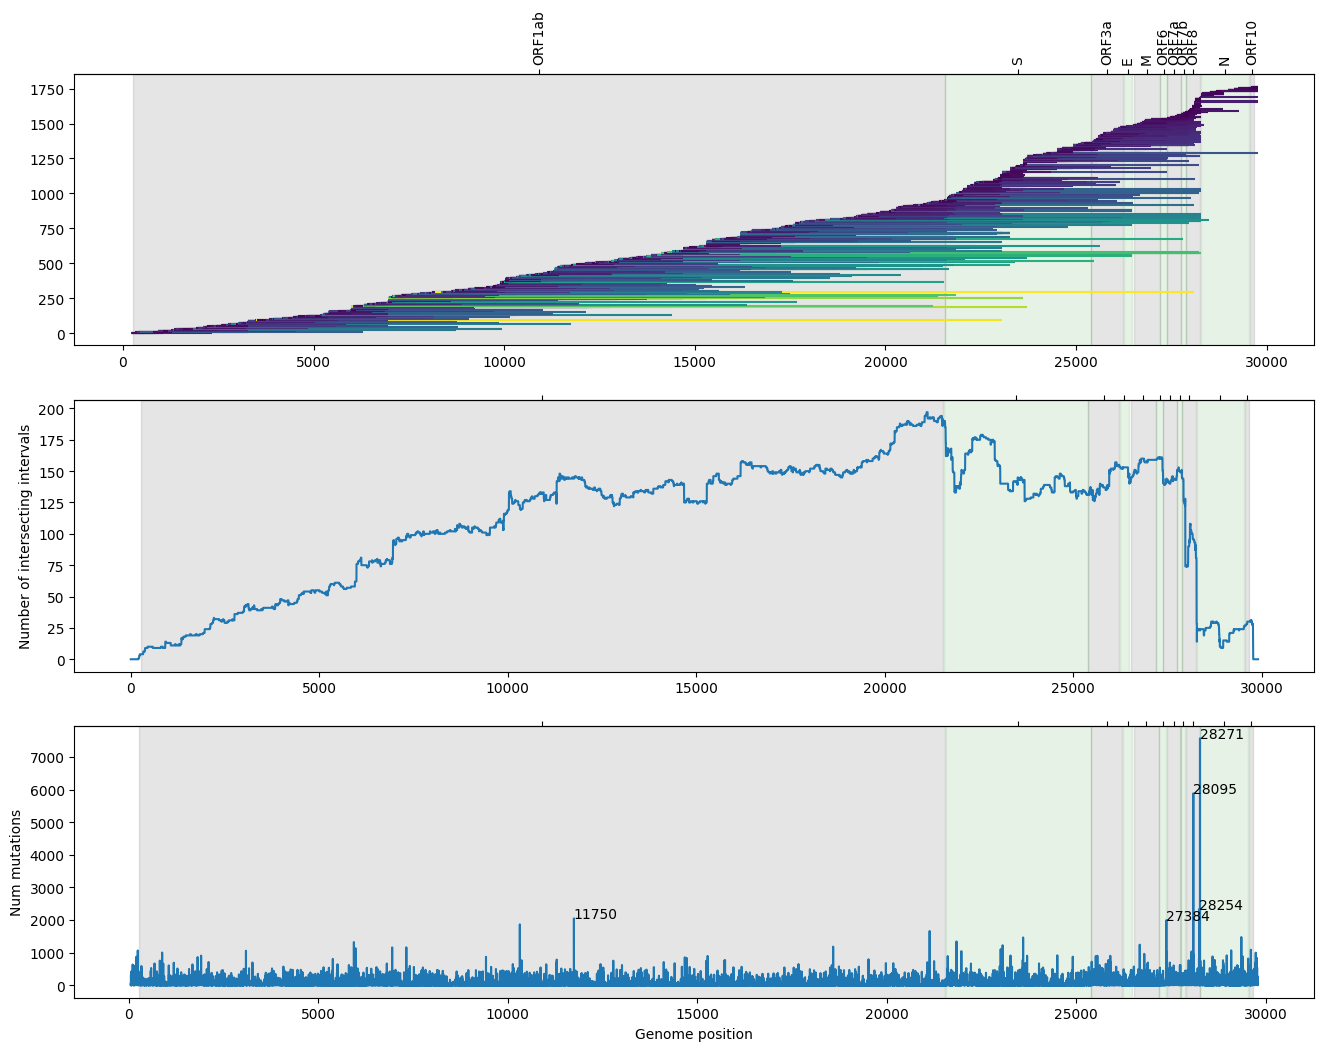

In [12]:
plot_breakpoints(df[df.max_descendant_samples > 1], ti, mutations_threshold=0.25, unique_only=False)

In [6]:
dfs = df[df.max_descendant_samples > 1]

# Intervals starting/ending at 28271

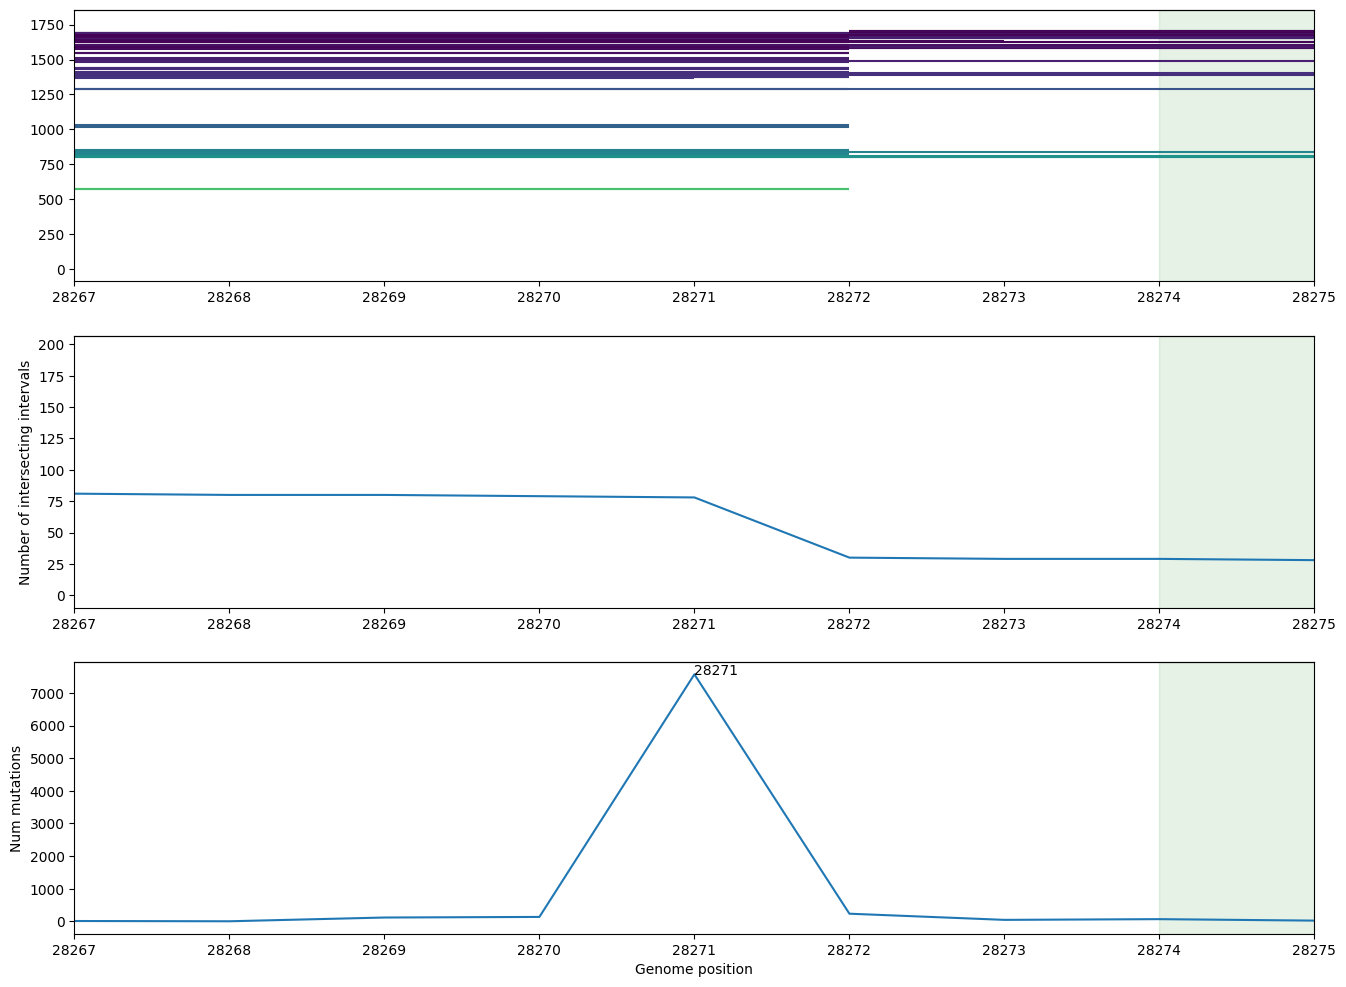

In [36]:
x = 28271
plot_breakpoints(dfs, ti, mutations_threshold=0.25, 
                xlim=(x-4, x+4))

We look at x + 1 because the interval is right-exclusive.

In [26]:
np.sum(dfs.breakpoint_interval_right == (x + 1))

57

In [27]:
np.sum(dfs.breakpoint_interval_left == (x + 1))

9

# Intervals starting/ending at 27972

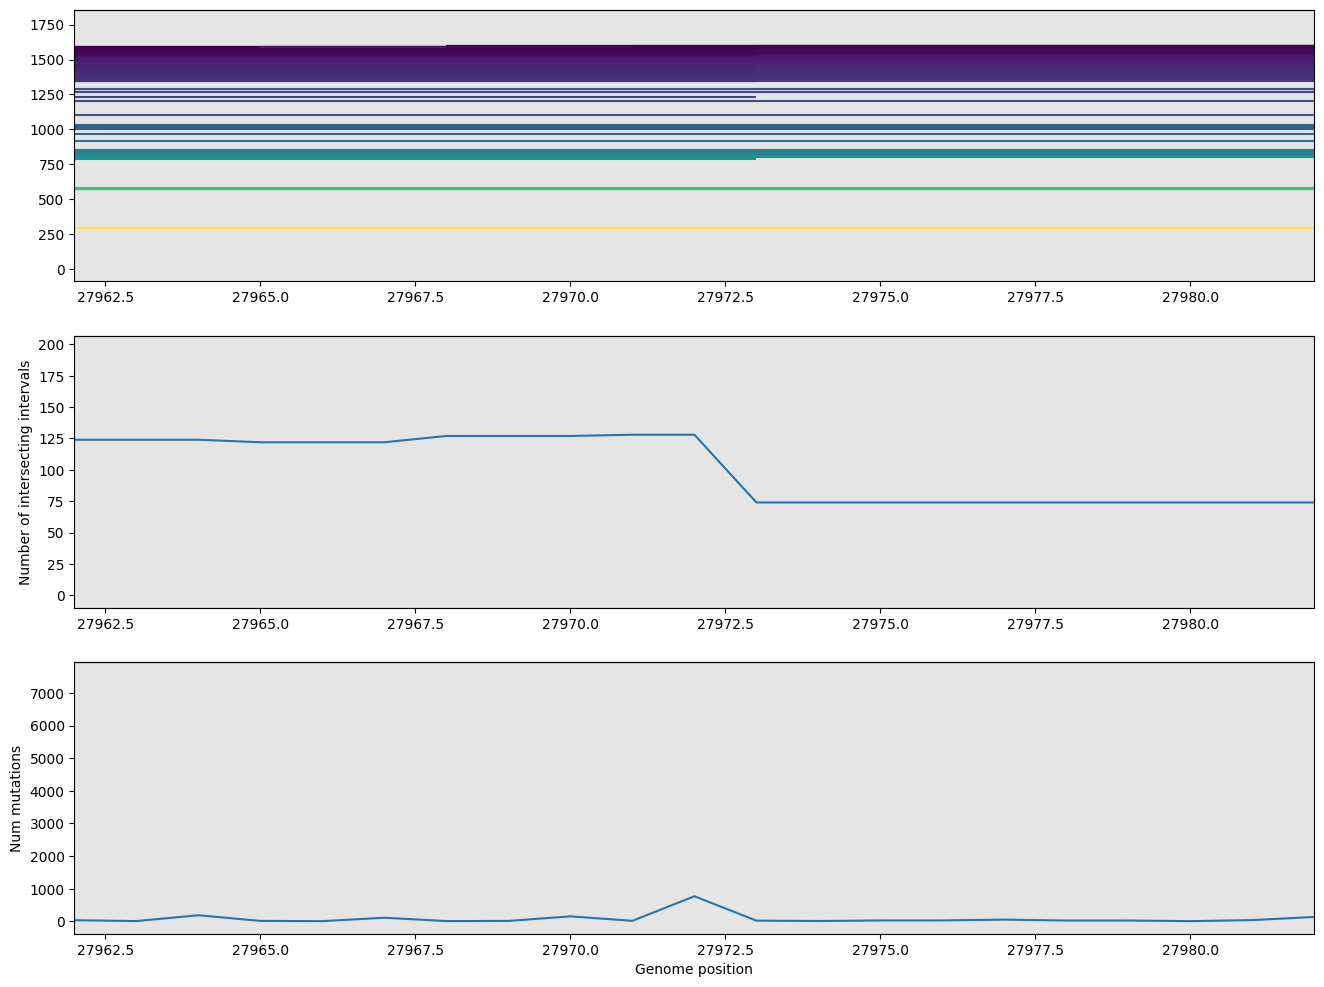

In [30]:
x = 27972
plot_breakpoints(dfs, ti, mutations_threshold=0.25, 
                xlim=(x-10, x+10))

In [35]:
np.sum(dfs.breakpoint_interval_right == (x + 1))

56

In [32]:
np.sum(dfs.breakpoint_interval_left == (x + 1))

2

# Site details

In [3]:
ti.site_summary(28271)

,property,value
0,id,27911
1,position,28271
2,ancestral_state,A
3,num_mutations,7572
4,private,4426
5,max_inheritors,515104
6,reversions,6811
7,immediate_reversions,69
8,transitions,26
9,transversions,159


In [29]:
ti.site_summary(27972)

,property,value
0,id,27618
1,position,27972
2,ancestral_state,C
3,num_mutations,770
4,private,551
5,max_inheritors,698458
6,reversions,328
7,immediate_reversions,2
8,transitions,739
9,transversions,25


# Export the data

In [9]:
df_mutations = pd.DataFrame({"position": ts.sites_position.astype(int), 
                             "num_mutations": ti.sites_num_mutations})
df_mutations

,position,num_mutations
0,56,3
1,57,62
2,58,5
3,59,21
4,60,10
...,...,...
29417,29799,24
29418,29800,48
29419,29801,52
29420,29802,37


In [10]:
df_mutations.to_csv("../data/wide_arg_site_info.csv")

In [14]:
df_recombs = ti.export_recombinant_breakpoints()
df_recombs

,causal_strain,causal_date,causal_lineage,node,max_descendant_samples,num_parents,total_cost,is_hmm_mutation_consistent,is_arg_hmm_path_identical,is_arg_hmm_path_length_consistent,...,is_parent_lineage_consistent,breakpoint,breakpoint_interval_left,breakpoint_interval_right,left_parent,right_parent,left_parent_imputed_lineage,right_parent_imputed_lineage,mrca,mrca_date
0,USA/WA-UW-2142/2020,2020-03-25,B.1.320,6799,1,2,4,True,True,True,...,True,379,92,380,1748,3829,B.1.371,B.1.320,1484,2020-03-08
1,Luxembourg/LNS0522318/2020,2020-04-04,B.1,10617,1,2,6,True,True,True,...,True,4320,2832,4321,9153,7627,B.1,B.1,179,2020-02-20
2,Luxembourg/LNS2129030/2020,2020-04-23,B.1,14596,1,2,6,True,True,True,...,True,2831,2828,2832,9153,3057,B.1,B.1,179,2020-02-20
3,India/TG-CCMB-L1090/2020,2020-05-13,B.1.1.306,17375,4,2,6,True,True,True,...,True,27382,25424,27383,17236,10105,B.1.1.306,B.1.1,179,2020-02-20
4,India/TG-CCMB-L1470/2020,2020-05-25,B.1,18231,2,2,3,True,True,True,...,True,27379,26736,27380,1089,17374,B.1,B.1.1.306,179,2020-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,Sweden/1468797164/2021,2021-06-30,B.1.1.7,1451366,1,2,9,True,False,False,...,False,8178,5389,8179,221898,1173001,B.1.1.7,B.1.1.7,64513,2020-09-14
4796,Sweden/4085798763/2021,2021-06-30,AY.122,1451405,1,3,16,True,True,True,...,True,22917,21619,22918,1145815,1335255,AY.122,Unknown (R),179,2020-02-20
4797,Sweden/4085798763/2021,2021-06-30,AY.122,1451405,1,3,16,True,True,True,...,True,28280,28112,28281,1335255,1395206,Unknown (R),B.1.1.7,179,2020-02-20
4798,USA/NC-CDC-LC0090621/2021,2021-06-30,B.1.1.7,1452444,1,2,8,False,True,True,...,False,9442,7043,9443,14699,808788,B.1.1,B.1.1.7,179,2020-02-20


In [15]:
df_recombs.to_csv("../data/wide_arg_recombinants.csv")

## Export long-arg recombs

In [3]:
ts_long = tszip.decompress("../data/upgma-mds-1000-md-30-mm-3-2022-06-30-recinfo2-gisaid-il.ts.tsz")
ti_long = sc2ts.utils.TreeInfo(ts_long)

Classifying mutations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1062072/1062072 [00:10<00:00, 104203.58it/s]


In [4]:
df_long_recombs = ti_long.export_recombinant_breakpoints()
df_long_recombs

,causal_strain,causal_date,causal_lineage,node,max_descendant_samples,num_parents,total_cost,is_hmm_mutation_consistent,is_arg_hmm_path_identical,is_arg_hmm_path_length_consistent,...,is_parent_lineage_consistent,breakpoint,breakpoint_interval_left,breakpoint_interval_right,left_parent,right_parent,left_parent_imputed_lineage,right_parent_imputed_lineage,mrca,mrca_date
0,USA/WA-UW-2142/2020,2020-03-25,B.1.320,6799,1,2,4,True,True,True,...,True,379,92,380,1748,3829,B.1.371,B.1.320,1484,2020-03-08
1,Luxembourg/LNS0522318/2020,2020-04-04,B.1,10617,1,2,6,True,True,True,...,True,4320,2832,4321,9153,7627,B.1,B.1,179,2020-02-20
2,Luxembourg/LNS2129030/2020,2020-04-23,B.1,14596,1,2,6,True,True,True,...,True,2831,2828,2832,9153,3057,B.1,B.1,179,2020-02-20
3,India/TG-CCMB-L1090/2020,2020-05-13,B.1.1.306,17375,3,2,6,True,True,True,...,True,27382,25424,27383,17236,10105,B.1.1.306,B.1.1,179,2020-02-20
4,India/TG-CCMB-L1470/2020,2020-05-25,B.1,18231,2,2,3,True,True,True,...,True,27379,26736,27380,1089,17374,B.1,B.1.1.306,179,2020-02-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,France/ARA-HCL722003302501/2022,2022-06-30,B.1.1.529,782566,1,2,6,True,True,True,...,False,27382,27260,27383,712894,578988,BA.5.2,Unknown,574542,2021-12-06
2305,Scotland/SCOT-15458/2022,2022-06-30,BA.5.3,782790,1,2,5,True,True,True,...,True,22104,18085,22105,773595,764821,BE.1,BF.6,675194,2022-03-24
2306,France/NAQ-CHUP-2206301113/2022,2022-06-30,BA.5.2.1,782924,1,2,11,False,True,True,...,True,4694,1541,4695,780659,771363,BA.5.2,BA.5.2.1,686272,2022-03-28
2307,USA/UT-UPHL-220715785919/2022,2022-06-30,BA.5.2,782984,1,2,6,True,True,True,...,True,9344,5285,9345,743955,779493,BA.5.2.1,Unknown (R),599488,2022-01-22


In [5]:
df_long_recombs.to_csv("../data/long_arg_recombinants.csv")

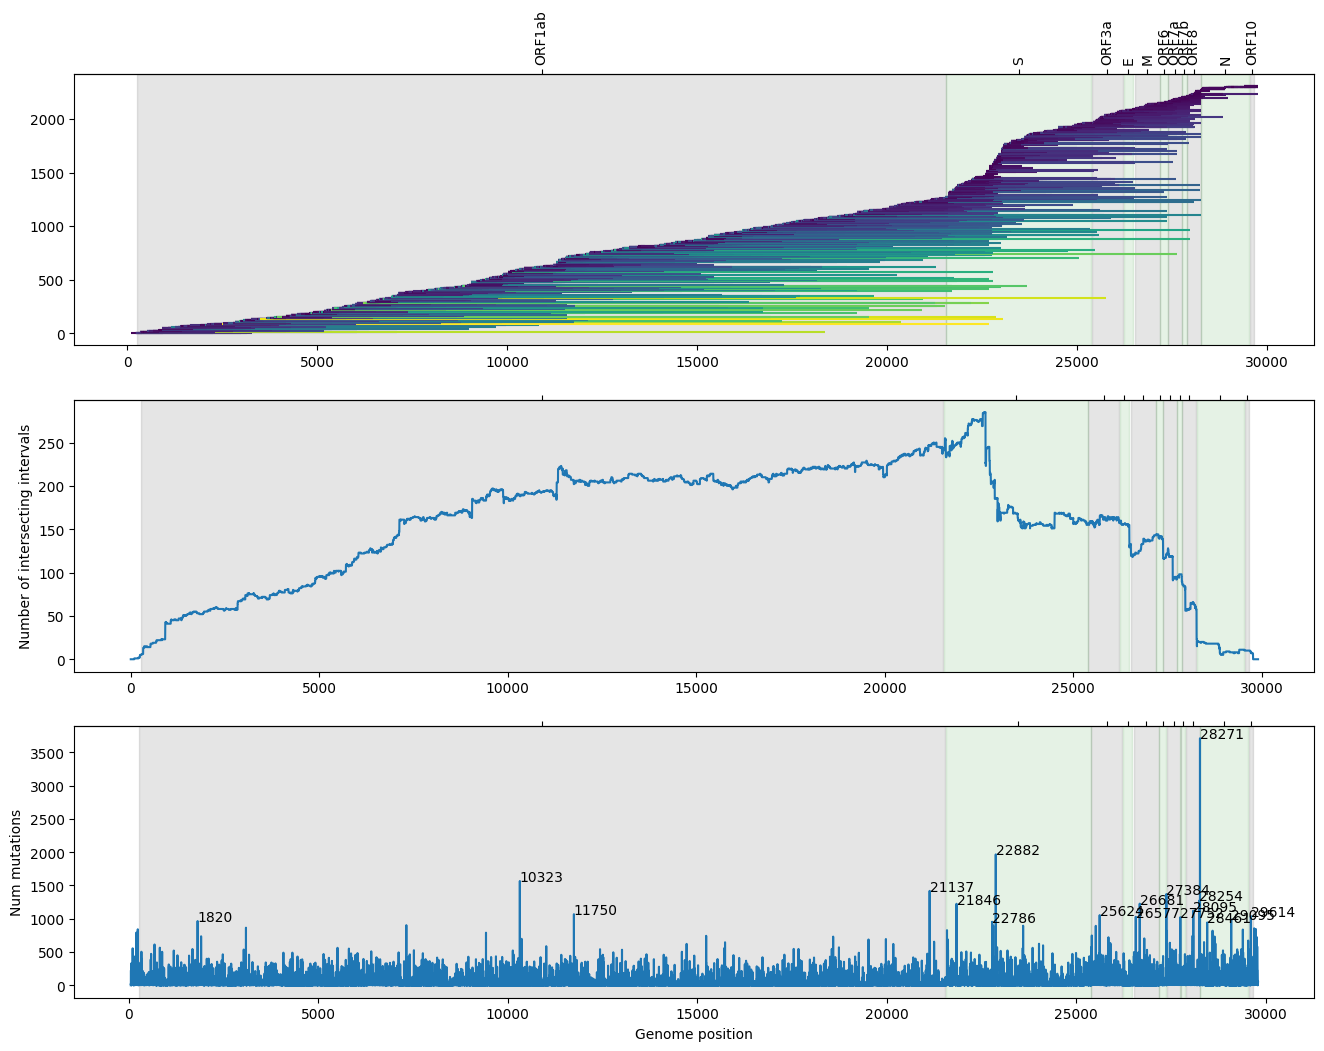

In [17]:
plot_breakpoints(df_long_recombs, ti_long, mutations_threshold=0.25, unique_only=False)

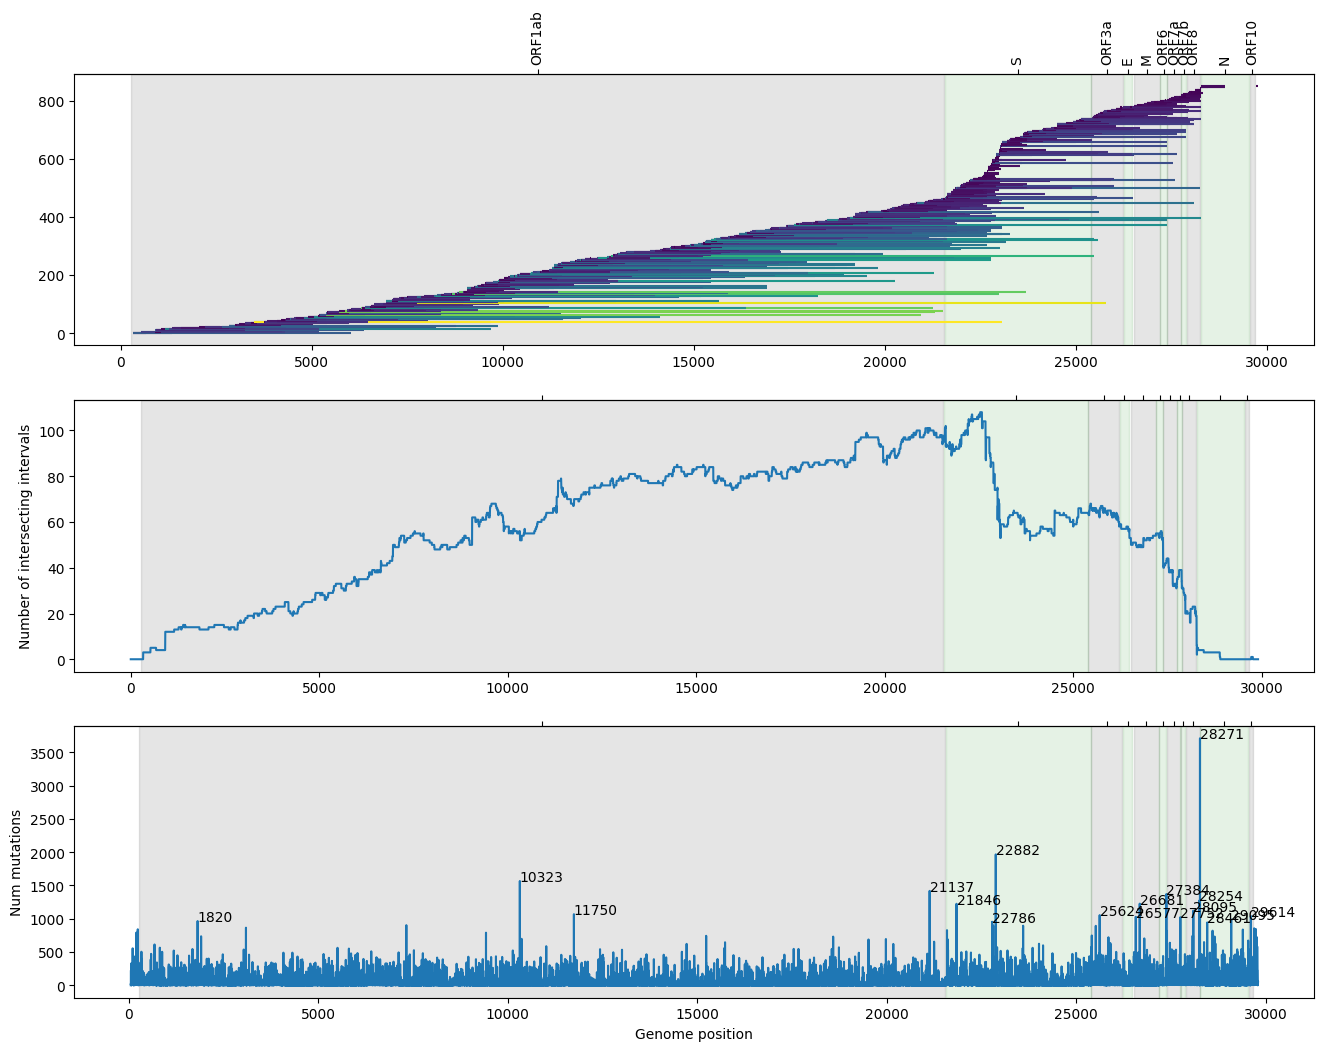

In [18]:
df_long_subset = df_long_recombs[df_long_recombs.max_descendant_samples > 1]

plot_breakpoints(df_long_subset, ti_long, mutations_threshold=0.25, unique_only=False)

In [20]:
df_mutations = pd.DataFrame({"position": ts_long.sites_position.astype(int), 
                             "num_mutations": ti_long.sites_num_mutations})
df_mutations

,position,num_mutations
0,56,2
1,57,27
2,58,8
3,59,25
4,60,10
...,...,...
29417,29799,23
29418,29800,49
29419,29801,29
29420,29802,37


In [21]:
df_mutations.to_csv("../data/long_arg_site_info.csv")